# Graph Neural Networks for Drug Discovery

This project is inspired by DeepFindr GNN project: <br>
https://www.youtube.com/@DeepFindr/videos <br>
https://github.com/deepfindr/gnn-project

### Libraries' installation 

In [2]:
!python --version

Python 3.8.16


In [3]:
import os
import torch
os.environ['TORCH'] = torch.__version__

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

     |████████████████████████████████| 9.4 MB 5.5 MB/s 
     |████████████████████████████████| 4.6 MB 5.4 MB/s 
     |████████████████████████████████| 280 kB 5.2 MB/s 


In [4]:
!pip install rdkit

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 29.3 MB 1.2 MB/s 


In [5]:
!pip install deepchem==2.6.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 608 kB 5.0 MB/s 
     |████████████████████████████████| 29.3 MB 1.2 MB/s 


### Imports

In [6]:
import os
import torch
import torch_geometric
from torch_geometric.datasets import MoleculeNet
from torch_geometric.data import Dataset

import rdkit
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole

import deepchem as dc

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from tqdm import tqdm 

In [7]:
print(f"Torch version: {torch.__version__}")
print(f"Cuda available: {torch.cuda.is_available()}")
print(f"Torch geometric version: {torch_geometric.__version__}")
print(f"RDKit version: {rdkit.__version__}")
print(f"DeepChem version: {dc.__version__}")

Torch version: 1.13.0+cu116
Cuda available: False
Torch geometric version: 2.2.0
RDKit version: 2022.09.1
DeepChem version: 2.6.1


In [8]:
# # mounting Google Drive
# from google.colab import drive
# drive.mount('/content/drive')

### Dataset Download / Loading

In [9]:
dataset_path = '/content/drive/MyDrive/COLAB_NOTEBOOKS/Graph_Neural_Network_Drug_Discovery_HIV_Dataset'

In [10]:
### Downloading the dataset with automatic creation of PyTorch Geometric in memory dataset
## The following line downloads and process the data - need to be run only once
#data = MoleculeNet(root=dataset_path, name='HIV')

## Afterwards, the dataset can be loaded from the drive
#data_path = os.path.join(dataset_path, 'hiv/processed/data.pt')
#data = torch.load(data_path)

In [11]:
# HIV CSV file
csv_path = os.path.join(dataset_path, 'hiv/raw/HIV.csv')
dataset_df = pd.read_csv(csv_path)
display(dataset_df.head())

,smiles,activity,HIV_active
0,CCC1=[O+][Cu-3]2([O+]=C(CC)C1)[O+]=C(CC)CC(CC)...,CI,0
1,C(=Cc1ccccc1)C1=[O+][Cu-3]2([O+]=C(C=Cc3ccccc3...,CI,0
2,CC(=O)N1c2ccccc2Sc2c1ccc1ccccc21,CI,0
3,Nc1ccc(C=Cc2ccc(N)cc2S(=O)(=O)O)c(S(=O)(=O)O)c1,CI,0
4,O=S(=O)(O)CCS(=O)(=O)O,CI,0


In [12]:
# from https://github.com/deepfindr/gnn-project/blob/main/dataset_featurizer.py

class MoleculeDataset(Dataset):
    def __init__(self, root, filename, test=False, transform=None, pre_transform=None):
        """
        root = Where the dataset should be stored. This folder is split
        into raw_dir (downloaded dataset) and processed_dir (processed data). 
        """
        self.test = test
        self.filename = filename
        super(MoleculeDataset, self).__init__(root, transform, pre_transform)
        
    @property
    def raw_file_names(self):
        """ If this file exists in raw_dir, the download is not triggered.
            (The download func. is not implemented here)  
        """
        return self.filename

    @property
    def processed_file_names(self):
        """ If these files are found in raw_dir, processing is skipped"""
        self.data = pd.read_csv(self.raw_paths[0]).reset_index()

        if self.test:
            return [f'data_test_{i}.pt' for i in list(self.data.index)]
        else:
            return [f'data_{i}.pt' for i in list(self.data.index)]
        

    def download(self):
        pass

    def process(self):
        self.data = pd.read_csv(self.raw_paths[0]).reset_index()
        featurizer = dc.feat.MolGraphConvFeaturizer(use_edges=True)
        for index, row in tqdm(self.data.iterrows(), total=self.data.shape[0]):
            # Featurize molecule
            mol = Chem.MolFromSmiles(row["smiles"])
            f = featurizer._featurize(mol)
            data = f.to_pyg_graph()
            data.y = self._get_label(row["HIV_active"])
            data.smiles = row["smiles"]
            if self.test:
                torch.save(data, 
                    os.path.join(self.processed_dir, 
                                 f'data_test_{index}.pt'))
            else:
                torch.save(data, 
                    os.path.join(self.processed_dir, 
                                 f'data_{index}.pt'))
            

    def _get_label(self, label):
        label = np.asarray([label])
        return torch.tensor(label, dtype=torch.int64)

    def len(self):
        return self.data.shape[0]

    def get(self, idx):
        """ - Equivalent to __getitem__ in pytorch
            - Is not needed for PyG's InMemoryDataset
        """
        if self.test:
            data = torch.load(os.path.join(self.processed_dir, 
                                 f'data_test_{idx}.pt'))
        else:
            data = torch.load(os.path.join(self.processed_dir, 
                                 f'data_{idx}.pt'))        
        return data


In [13]:
molecule_data_path = os.path.join(dataset_path, 'hiv/')
dataset = MoleculeDataset(root=molecule_data_path, filename='HIV.csv')


In [18]:
print(type(dataset[0]))
print('Example molecule: Edge index (graph connections)')
print(dataset[0].edge_index.t())
print('Example molecule: Node embeddings')
print(dataset[0].x)
print('Example molecule: Edge attributes')
print(dataset[0].edge_attr)
print('Example molecule: HIV attributes')
print(dataset[0].y)

<class 'torch_geometric.data.data.Data'>
Example molecule: Edge index (graph connections)
tensor([[ 0,  1],
        [ 1,  0],
        [ 1,  2],
        [ 2,  1],
        [ 2,  3],
        [ 3,  2],
        [ 3,  4],
        [ 4,  3],
        [ 4,  5],
        [ 5,  4],
        [ 5,  6],
        [ 6,  5],
        [ 6,  7],
        [ 7,  6],
        [ 7,  8],
        [ 8,  7],
        [ 6,  9],
        [ 9,  6],
        [ 4, 10],
        [10,  4],
        [10, 11],
        [11, 10],
        [11, 12],
        [12, 11],
        [12, 13],
        [13, 12],
        [11, 14],
        [14, 11],
        [14, 15],
        [15, 14],
        [15, 16],
        [16, 15],
        [16, 17],
        [17, 16],
        [15, 18],
        [18, 15],
        [ 9,  2],
        [ 2,  9],
        [18,  4],
        [ 4, 18]])
Example molecule: Node embeddings
tensor([[ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  1

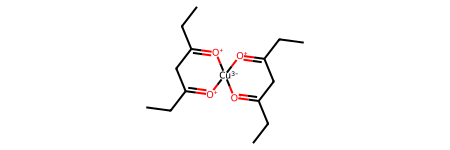

In [21]:
example_molecule = Chem.MolFromSmiles(dataset_df.loc[0, "smiles"])
example_molecule

In [ ]:
# Dat

In [ ]:
## Oversampling of data oversample data.py

In [ ]:
### from https://github.com/deepfindr/gnn-project/blob/main/train.py
## get model
import torch
import torch.nn.functional as F 
from torch.nn import Linear, BatchNorm1d, ModuleList
from torch_geometric.nn import TransformerConv, TopKPooling 
from torch_geometric.nn import global_mean_pool as gap, global_max_pool as gmp
torch.manual_seed(42)

class GNN(torch.nn.Module):
    def __init__(self, feature_size, model_params):
        super(GNN, self).__init__()
        embedding_size = model_params["model_embedding_size"]
        n_heads = model_params["model_attention_heads"]
        self.n_layers = model_params["model_layers"]
        dropout_rate = model_params["model_dropout_rate"]
        top_k_ratio = model_params["model_top_k_ratio"]
        self.top_k_every_n = model_params["model_top_k_every_n"]
        dense_neurons = model_params["model_dense_neurons"]
        edge_dim = model_params["model_edge_dim"]

        self.conv_layers = ModuleList([])
        self.transf_layers = ModuleList([])
        self.pooling_layers = ModuleList([])
        self.bn_layers = ModuleList([])

        # Transformation layer
        self.conv1 = TransformerConv(feature_size, 
                                    embedding_size, 
                                    heads=n_heads, 
                                    dropout=dropout_rate,
                                    edge_dim=edge_dim,
                                    beta=True) 

        self.transf1 = Linear(embedding_size*n_heads, embedding_size)
        self.bn1 = BatchNorm1d(embedding_size)

        # Other layers
        for i in range(self.n_layers):
            self.conv_layers.append(TransformerConv(embedding_size, 
                                                    embedding_size, 
                                                    heads=n_heads, 
                                                    dropout=dropout_rate,
                                                    edge_dim=edge_dim,
                                                    beta=True))

            self.transf_layers.append(Linear(embedding_size*n_heads, embedding_size))
            self.bn_layers.append(BatchNorm1d(embedding_size))
            if i % self.top_k_every_n == 0:
                self.pooling_layers.append(TopKPooling(embedding_size, ratio=top_k_ratio))
            

        # Linear layers
        self.linear1 = Linear(embedding_size*2, dense_neurons)
        self.linear2 = Linear(dense_neurons, int(dense_neurons/2))  
        self.linear3 = Linear(int(dense_neurons/2), 1)  

    def forward(self, x, edge_attr, edge_index, batch_index):
        # Initial transformation
        x = self.conv1(x, edge_index, edge_attr)
        x = torch.relu(self.transf1(x))
        x = self.bn1(x)

        # Holds the intermediate graph representations
        global_representation = []

        for i in range(self.n_layers):
            x = self.conv_layers[i](x, edge_index, edge_attr)
            x = torch.relu(self.transf_layers[i](x))
            x = self.bn_layers[i](x)
            # Always aggregate last layer
            if i % self.top_k_every_n == 0 or i == self.n_layers:
                x , edge_index, edge_attr, batch_index, _, _ = self.pooling_layers[int(i/self.top_k_every_n)](
                    x, edge_index, edge_attr, batch_index
                    )
                # Add current representation
                global_representation.append(torch.cat([gmp(x, batch_index), gap(x, batch_index)], dim=1))
    
        x = sum(global_representation)

        # Output block
        x = torch.relu(self.linear1(x))
        x = F.dropout(x, p=0.8, training=self.training)
        x = torch.relu(self.linear2(x))
        x = F.dropout(x, p=0.8, training=self.training)
        x = self.linear3(x)

        return 